In [1]:
import argparse
import pickle
import torch
import os
import glob
import re

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
from pathlib import Path
from statistics import mean

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from beautifultable import BeautifulTable
from pathlib import Path
from incremental_rl.train import IncrementalExpt, set_one_thread
from sys import platform
if platform == "darwin":
    import matplotlib as mpl
    mpl.use("Qt5Agg")

# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.XKCD_COLORS)
colors = list(colors.keys())
colors.remove('w')

/home/vasan/src/rtrl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Set dimensions in the background of matplotlib. Call both functions for pretty plots :) 

def setsizes():
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['lines.markeredgewidth'] = 1.0
    plt.rcParams['lines.markersize'] = 3

    plt.rcParams['xtick.labelsize'] = 14.0
    plt.rcParams['ytick.labelsize'] = 14.0
    plt.rcParams['xtick.direction'] = "out"
    plt.rcParams['ytick.direction'] = "in"
    plt.rcParams['lines.linewidth'] = 3.0
    plt.rcParams['ytick.minor.pad'] = 50.0

    # https://tex.stackexchange.com/questions/18687/how-to-generate-pdf-without-any-type3-fonts
    plt.rcParams['pdf.fonttype'] = 42   

def setaxes():
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', which='minor', width=2, length=3,
                   labelsize=12, pad=8)
    ax.tick_params(axis='both', direction='out', which='major', width=2, length=8,
                   labelsize=12, pad=8)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    for tick in ax.xaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)

def plt_formatter():
    setsizes()
    setaxes()

In [3]:
### Helper functions to generate plots for the paper

# Assign colors for each choice of timeout
color_dict = {
    # simulation colors
    1:      'tab:blue',
    2:      'tab:orange',
    5:      'tab:green',
    10:     'tab:red',
    25:     'tab:purple', 
    50:     'tab:brown', 
    100:    'tab:pink', 
    500:    'tab:gray', 
    1000:   'tab:olive', 
    5000:   'tab:cyan',
    # real robot colors
    '3s':      'tab:blue',
    '6s':      'tab:orange',
    '15s':     'tab:red',
    '30s':     'tab:green',
}

def human_format_numbers(num, use_float=False):
    # Make human readable short-forms for large numbers
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    if use_float:
        return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
    return '%d%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


def set_labels(title, xlabel="Timesteps", ylabel="Return", labelpad=25):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    h = plt.ylabel(ylabel, fontsize=14, labelpad=labelpad)
    h.set_rotation(0)
    (ticks, texts) = plt.xticks()
    try:
        new_labels = [human_format_numbers(int(k.get_text())) for k in texts]
    except:
        new_labels = [human_format_numbers(int(k)) for k in ticks]
    plt.xticks(ticks=ticks, labels=new_labels)
    plt.grid()
    plt.tight_layout()


In [4]:
def smoothed_curve(returns, ep_lens, x_tick=5000, window_len=5000):
    """
    Args:
        returns: 1-D numpy array with episodic returs
        ep_lens: 1-D numpy array with episodic returs
        x_tick (int): Bin size
        window_len (int): Length of averaging window
    Returns:
        A numpy array
    """
    rets = []
    x = []
    cum_episode_lengths = np.cumsum(ep_lens)

    if cum_episode_lengths[-1] >= x_tick:
        y = cum_episode_lengths[-1] + 1
        steps_show = np.arange(x_tick, y, x_tick)

        for i in range(len(steps_show)):
            rets_in_window = returns[(cum_episode_lengths > max(0, x_tick * (i + 1) - window_len)) *
                                     (cum_episode_lengths < x_tick * (i + 1))]
            if rets_in_window.any():
                rets.append(np.mean(rets_in_window))
                x.append((i+1) * x_tick)

    return np.array(rets), np.array(x)

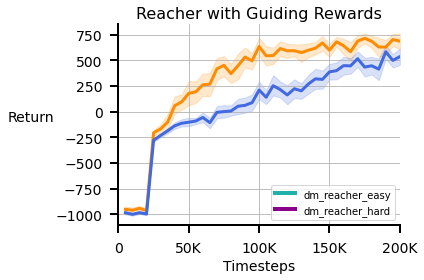

In [5]:
# Plot returns from numpy txt files with returns and episode lengths

envs = ["ar_reacher_easy", "ar_reacher_hard"]
color_palette = {
    "ar_reacher_easy": "darkorange",
    "ar_reacher_hard": "royalblue",
    # "vt_reacher_easy": "lightseagreen",
    "vt_reacher_easy": "mediumaquamarine",
    "vt_reacher_hard": "darkmagenta",
    "ftl_reacher_easy": "teal",
    "ftl_reacher_hard": "deeppink",
}
basepath = "/home/vasan/src/rl_suite/rl_suite/misc/results"

df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])

for env in envs:
    all_paths = glob.glob(f"{basepath}/{env}/*_returns.txt")
    assert len(all_paths) > 0
    counter = 0
    for fp in all_paths:
        counter += 1
        data = np.loadtxt(fp)
        try:
            rets, timesteps = smoothed_curve(data[1], data[0], x_tick=5000, window_len=5000)
            for r, t in zip(rets, timesteps):
                df = pd.concat([df, pd.DataFrame.from_records([{'env': env, 'seed':counter, 'step':t, 'avg_ret':r}])])
        except IndexError as e:
            print(f"Run {fp} incomplete. It was not added to the plot")

# Plot
# for env in envs:
plt.figure()
plt_formatter()
plt.xlim(0, 200000)
# sns.lineplot(x="step", y='avg_ret', data=df[df['env']==env], hue='env', palette=color_palette)
sns.lineplot(x="step", y='avg_ret', data=df, hue='env', palette=color_palette)
title = "Reacher with Guiding Rewards"
set_labels(title, labelpad=25)


legend_elements = [Line2D([0], [0], color='lightseagreen', lw=4, label='dm_reacher_easy'),
                   Line2D([0], [0], color='darkmagenta', lw=4, label='dm_reacher_hard'),]
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.locator_params(axis='x', nbins=8)
plt.savefig(title+'.pdf', dpi=200)
plt.show()
plt.close()

In [8]:
from rl_suite.algo.mlp_policies import SquashedGaussianMLPActor
from rl_suite.misc.dm_reacher_comparisons import FixedTimeLimitReacher

EP = 100
obs_dim = 6
action_dim = 2
device = torch.device('cuda')
actor_nn_params = {
    'mlp': {
        'hidden_sizes': [512, 512],
        'activation': 'relu',
    }
}
model_paths = ["/home/vasan/src/rl_suite/rl_suite/misc/results/ftl_reacher_easy/2023-07-24-19_25_11_seed-1_model.pt",
             "/home/vasan/src/rl_suite/rl_suite/misc/results/vt_reacher_easy/2023-07-24-19_25_11_seed-1_model.pt"]
actor = SquashedGaussianMLPActor(obs_dim, action_dim, actor_nn_params, device)

for model_path in model_paths:
    model_dict = torch.load(model_path)
    actor.load_state_dict(model_dict['actor'])

    env = FixedTimeLimitReacher(seed=42, mode="easy", use_image=False)
    env.timeout = 10000
    rets = []
    ep_lens = []
    steps_to_goal = []
    for ep in range(EP):
        obs = env.reset()
        ret = 0
        reached_goal = False
        step = 0
        while True:
            # Take action
            x = torch.tensor(obs.astype(np.float32)).to(device).unsqueeze(0)
            with torch.no_grad():
                mu, action, _, log_std = actor(x)
            action = action.cpu().data.numpy()

            # Receive reward and next state
            next_obs, R, done, _ = env.step(action)
            if (R == 1) and (not reached_goal):
                reached_goal = True
                steps_to_goal.append(step)

            ret += R
            step += 1

            # Termination
            if done:
                rets.append(ret)
                ep_lens.append(step)
                print(f"Episode {ep+1} ended in {step} steps with return {ret}")
                break
            obs = next_obs

    print(rets, steps_to_goal)


Using normal distribution initialization.
Non visual dm reacher easy
Episode 1 ended in 10000 steps with return 9952.0
Episode 2 ended in 10000 steps with return 7.0
Episode 3 ended in 10000 steps with return 9997.0
Episode 4 ended in 10000 steps with return 9992.0
Episode 5 ended in 10000 steps with return 9979.0
Episode 6 ended in 10000 steps with return 9995.0
Episode 7 ended in 10000 steps with return 10000.0
Episode 8 ended in 10000 steps with return 9659.0
Episode 9 ended in 10000 steps with return 8.0
Episode 10 ended in 10000 steps with return 10000.0
Episode 11 ended in 10000 steps with return 6.0
Episode 12 ended in 10000 steps with return 9993.0
Episode 13 ended in 10000 steps with return 17.0
Episode 14 ended in 10000 steps with return 9988.0
Episode 15 ended in 10000 steps with return 9973.0
Episode 16 ended in 10000 steps with return 529.0
Episode 17 ended in 10000 steps with return 9953.0
Episode 18 ended in 10000 steps with return 9979.0
Episode 19 ended in 10000 steps 